In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, Slider, CustomJS, Legend, LegendItem
from bokeh.layouts import column
from bokeh.palettes import Category20
from bokeh.palettes import TolRainbow
from bokeh.transform import factor_cmap
from bokeh.plotting import output_notebook

from itertools import cycle
# Ensure Bokeh plots are displayed in the notebook
output_notebook()


Loading BokehJS ...

# Generel DF prep

In [11]:
filepath = r'C:\Users\AnjaBrocklehurst\Documents\Data\SBTi Dataviz\ByCompany.csv'
Comp = pd.read_csv(filepath, sep=';')
filepath = r'C:\Users\AnjaBrocklehurst\Documents\Data\SBTi Dataviz\ByTargets.csv'
Targ = pd.read_csv(filepath, sep=';')

In [12]:
#Targ.info()
#Comp.info()
Targ = Targ.copy()
Comp = Comp.copy()

### Categorizing sectors in both Comp and Targ

In [13]:
# Mapping of sectors to categories
sector_category_map = {
    'Ground Transportation - Railroads Transportation': 'Transportation',
    'Semiconductors and Semiconductors Equipment': 'Technology',
    'Air Freight Transportation and Logistics': 'Transportation',
    'Trading Companies and Distributors, and Commercial Services and Supplies': 'Commercial Services',
    'Water Transportation - Water Transportation': 'Transportation',
    'Food and Beverage Processing': 'Food and Beverage',
    'Telecommunication Services': 'Telecommunication',
    'Construction and Engineering': 'Construction',
    'Pharmaceuticals, Biotechnology and Life Sciences': 'Healthcare',
    'Professional Services': 'Professional Services',
    'Containers and Packaging': 'Packaging',
    'Real Estate': 'Real Estate',
    'Consumer Durables, Household and Personal Products': 'Consumer Products',
    'Electric Utilities and Independent Power Producers and Energy Traders (including Fossil, Alternative and Nuclear Energy)': 'Energy',
    'Retailing': 'Retail',
    'Mining - Iron, Aluminum, Other Metals': 'Mining',
    'Textiles, Apparel, Footwear and Luxury Goods': 'Consumer Products',
    'Software and Services': 'Technology',
    'Hotels, Restaurants and Leisure, and Tourism Services': 'Hospitality',
    'Electrical Equipment and Machinery': 'Manufacturing',
    'Food Production - Agricultural Production': 'Food Production',
    'Building Products': 'Construction',
    'Food and Staples Retailing': 'Retail',
    'Automobiles and Components': 'Automotive',
    'Forest and Paper Products - Forestry, Timber, Pulp and Paper, Rubber': 'Forestry and Paper Products',
    'Tobacco': 'Tobacco',
    'Solid Waste Management Utilities': 'Utilities',
    'Chemicals': 'Chemicals',
    'Construction Materials': 'Construction',
    'Technology Hardware and Equipment': 'Technology',
    'Mining - Other (Rare Minerals, Precious Metals and Gems)': 'Mining',
    'Water Utilities': 'Utilities',
    'Homebuilding': 'Construction',
    'Ground Transportation - Highways and Railtracks': 'Transportation',
    'Food Production - Animal Source Food Production': 'Food Production',
    'Healthcare Equipment and Supplies': 'Healthcare',
    'Air Transportation - Airport Services': 'Transportation',
    'Media': 'Media',
    'Banks, Diverse Financials, Insurance': 'Financial Services',
    'Ground Transportation - Trucking Transportation': 'Transportation',
    'Specialized Consumer Services': 'Consumer Services',
    'Specialized Financial Services, Consumer Finance, Insurance Brokerage Firms': 'Financial Services',
    'Healthcare Providers and Services, and Healthcare Technology': 'Healthcare',
    'Water Transportation - Ports and Services': 'Transportation',
    'Air Transportation - Airlines': 'Transportation',
    'Aerospace and Defense': 'Defense',
    'Tires': 'Automotive',
    'Education Services': 'Education',
    'Gas Utilities': 'Utilities'
}

# Function to map sectors to categories
def map_category(sector):
    return sector_category_map.get(sector, 'Unknown')
# Apply the function to the 'sector' column
Targ['sectorCat'] = Targ['sector'].apply(map_category)
Comp['sectorCat'] = Comp['sector'].apply(map_category)
# Display the DataFrame
Targ['sectorCat'].unique()
# Place sectorCat next to sector in the DataFrame
Targ = Targ[['sector', 'sectorCat'] + [col for col in Targ.columns if col not in ['sector', 'sectorCat']]]
Comp = Comp[['sector', 'sectorCat'] + [col for col in Comp.columns if col not in ['sector', 'sectorCat']]]

### Editing Targ df

In [14]:
#make Targ['date_published'] a datetime object
Targ['date_published'] = pd.to_datetime(Targ['date_published'], errors='coerce')
#seperate year from date_published
Targ['Comitted year'] = Targ['date_published'].dt.year
#sort targ by year
Targ = Targ.sort_values(by='Comitted year', ascending=True)
# limit to 2015-2024
Targ = Targ[Targ['Comitted year'].between(2015, 2024)]
#check if year is sorted correctly
Targ['Comitted year'].unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [15]:
# Remove duplicates of stbi_id in Targ to make counting easier
Targ = Targ.drop_duplicates(subset=['company_name'])

### Editing Comp df

In [16]:
Comp['date_updated'] = pd.to_datetime(Comp['date_updated'], errors='coerce')
#isolating year in Comp
Comp['year_updated'] = Comp['date_updated'].dt.year
Comp=Comp.sort_values(by='year_updated', ascending=True)

C:\Users\AnjaBrocklehurst\AppData\Local\Temp\ipykernel_31504\3877062900.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  Comp['date_updated'] = pd.to_datetime(Comp['date_updated'], errors='coerce')


In [17]:
#group by year_updated and count the number commitment removed
#Comp['year_updated'] = pd.to_numeric(Comp['year_updated'], errors='coerce')

# Prep of DK data

In [18]:
#create dataframe with only locations with denmark
Targ_dk = Targ[Targ['location'].str.contains('Denmark', na=False)]
Comp_dk = Comp[Comp['location'].str.contains('Denmark', na=False)]

# Viz af DK

## Dk companies comitting over the last years

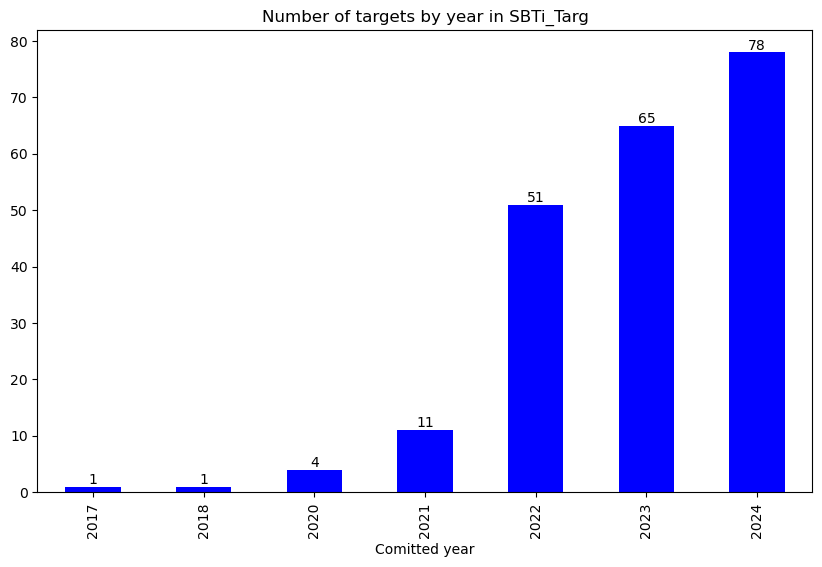

In [19]:
# Amount of targets by year in SBTi_Targ
ax = Targ_dk['Comitted year'].value_counts().sort_index().plot(kind='bar', figsize=(10, 6), color='blue')
plt.title('Number of targets by year in SBTi_Targ')
# Add data labels on top of the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 0.5, int(p.get_height()), ha='center')
plt.show()


## Types of sectors signing up

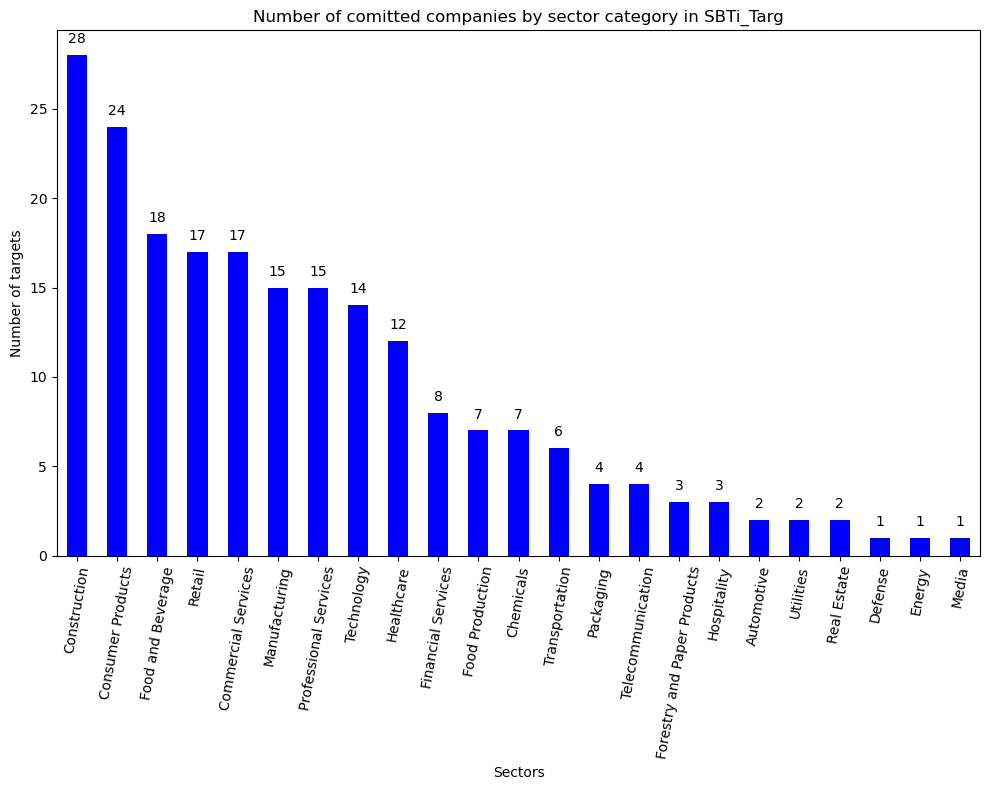

In [20]:
# Sort by size instead of index
Targ_dk['sectorCat'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(10, 8), color='blue')

plt.title('Number of comitted companies by sector category in SBTi_Targ')

# Add annotations on each bar showing the amount of targets
for i, v in enumerate(Targ_dk['sectorCat'].value_counts().sort_values(ascending=False)):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=80,verticalalignment='top')
plt.xlabel('Sectors')
plt.ylabel('Number of targets')
plt.tight_layout()
plt.show()

In [21]:
sector_count = Targ_dk.groupby('sectorCat').size().reset_index(name='count')
sector_count

,sectorCat,count
0,Automotive,2
1,Chemicals,7
2,Commercial Services,17
3,Construction,28
4,Consumer Products,24
5,Defense,1
6,Energy,1
7,Financial Services,8
8,Food Production,7
9,Food and Beverage,18


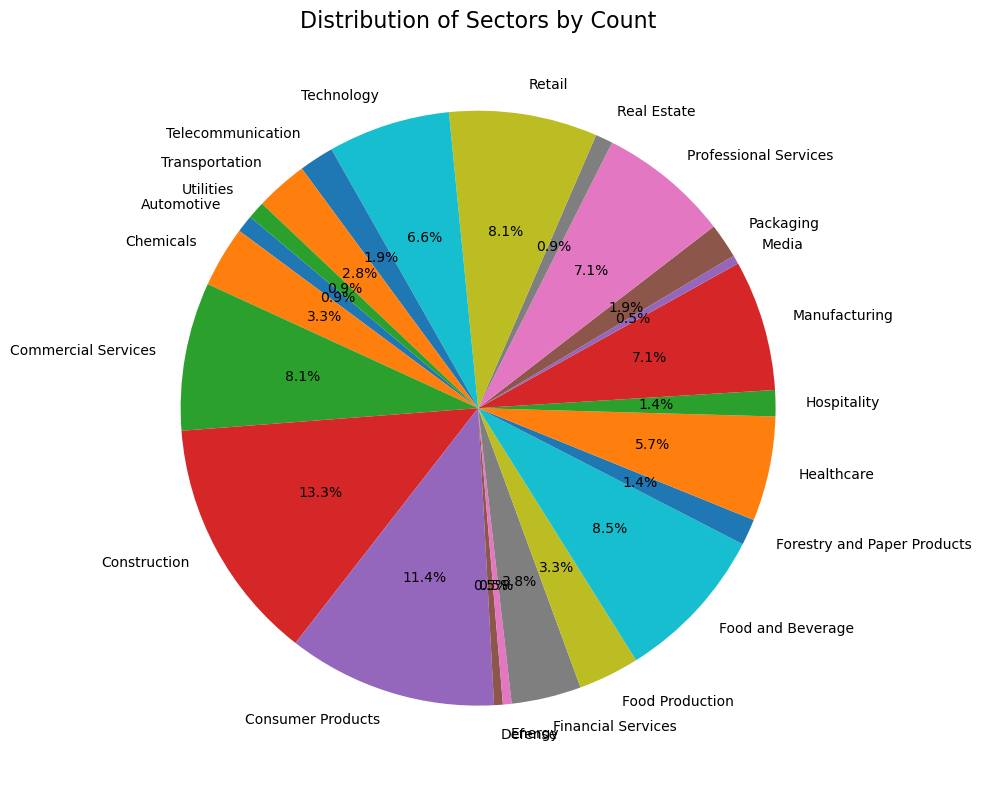

In [22]:
plt.figure(figsize=(10, 8))
#colors = plt.cm.Paired(range(len(sector_count)))  # Use a colormap for diverse colors

# Pie chart
plt.pie(
    sector_count['count'], 
    labels=sector_count['sectorCat'], 
    autopct='%1.1f%%', 
    startangle=140, 
    #colors=colors
)

# Add a title
plt.title('Distribution of Sectors by Count', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

## Growth in sectors

C:\Users\AnjaBrocklehurst\AppData\Local\Temp\ipykernel_31504\773736690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Targ_dk['Comitted year'] = pd.to_numeric(Targ_dk['Comitted year'], errors='coerce')


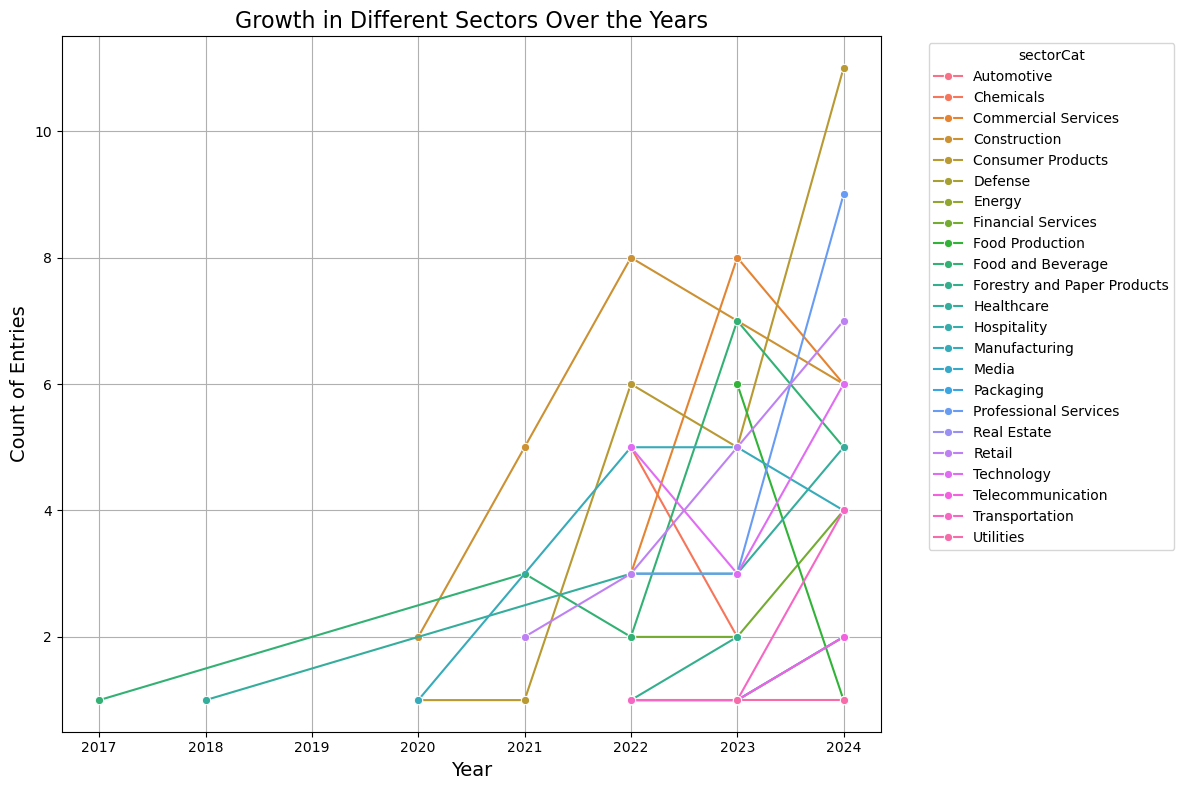

In [23]:
# Ensure 'target_year' is numeric
Targ_dk['Comitted year'] = pd.to_numeric(Targ_dk['Comitted year'], errors='coerce')

# Group by sector and target_year, then count the entries
sector_growth = Targ_dk.groupby(['sectorCat', 'Comitted year']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=sector_growth, x='Comitted year', y='count', hue='sectorCat', marker='o')

# Customize the plot
plt.title('Growth in Different Sectors Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Entries', fontsize=14)
plt.legend(title='sectorCat', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\AnjaBrocklehurst\AppData\Local\Temp\ipykernel_31504\2389542943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Targ_dk['Comitted year'] = pd.to_numeric(Targ_dk['Comitted year'], errors='coerce')


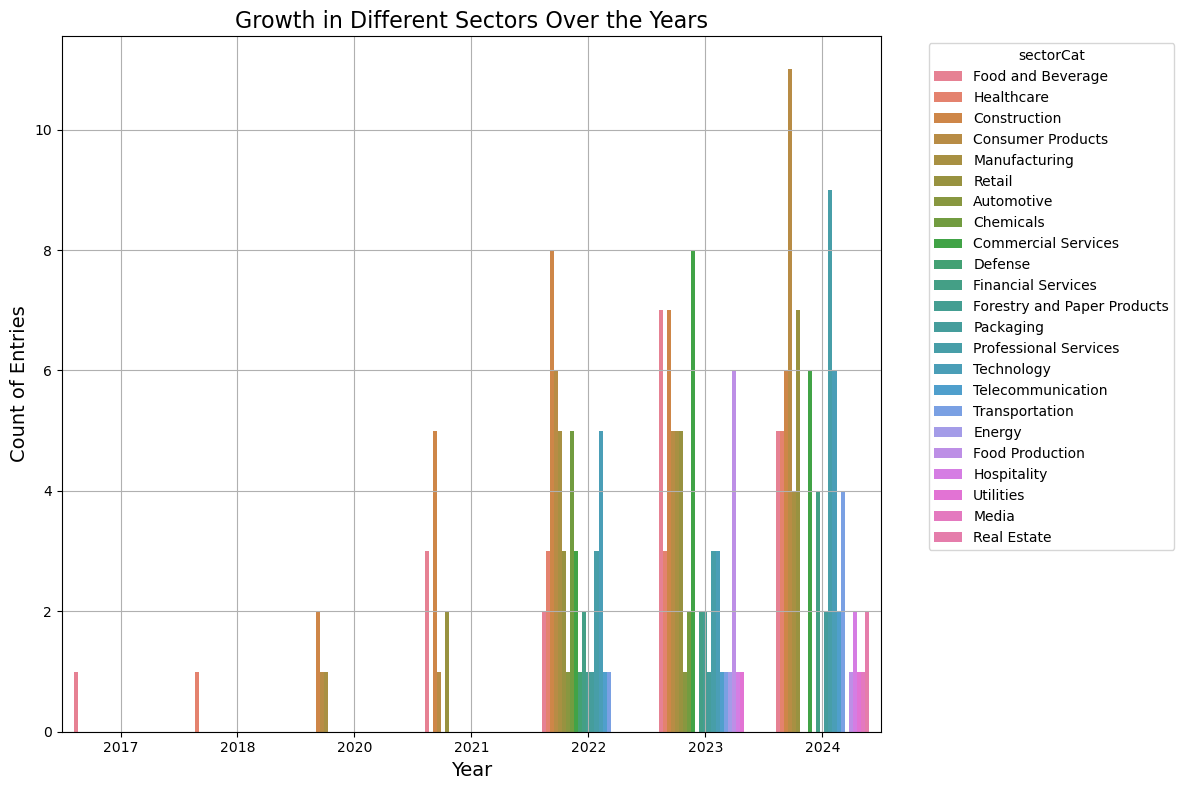

In [24]:
# Ensure 'target_year' is numeric
Targ_dk['Comitted year'] = pd.to_numeric(Targ_dk['Comitted year'], errors='coerce')

# Group by sector and target_year, then count the entries
sector_growth = Targ_dk.groupby(['sectorCat', 'Comitted year']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=sector_growth, x='Comitted year', y='count', hue='sectorCat')

# Customize the plot
plt.title('Growth in Different Sectors Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Entries', fontsize=14)
plt.legend(title='sectorCat', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

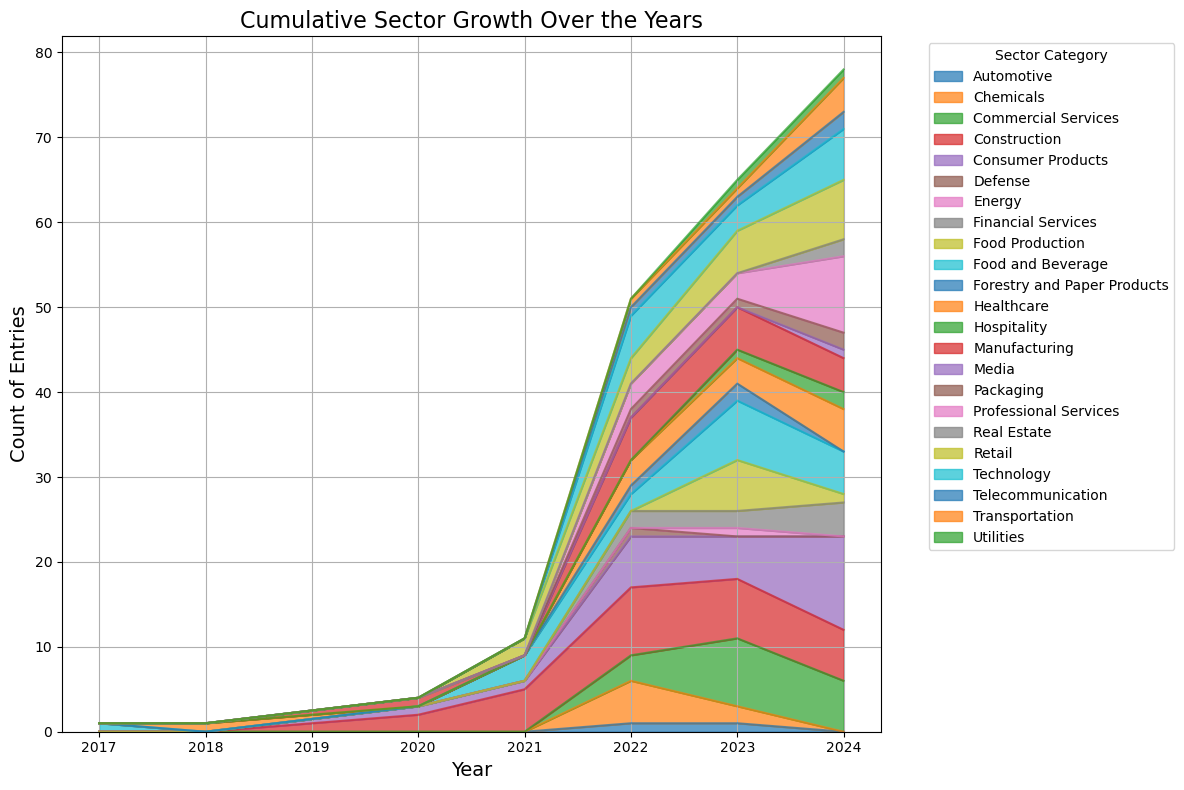

In [25]:
sector_pivot = sector_growth.pivot(index='Comitted year', columns='sectorCat', values='count').fillna(0)

# Plot
sector_pivot.plot.area(figsize=(12, 8), alpha=0.7)
plt.title("Cumulative Sector Growth Over the Years", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Count of Entries", fontsize=14)
plt.legend(title="Sector Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()

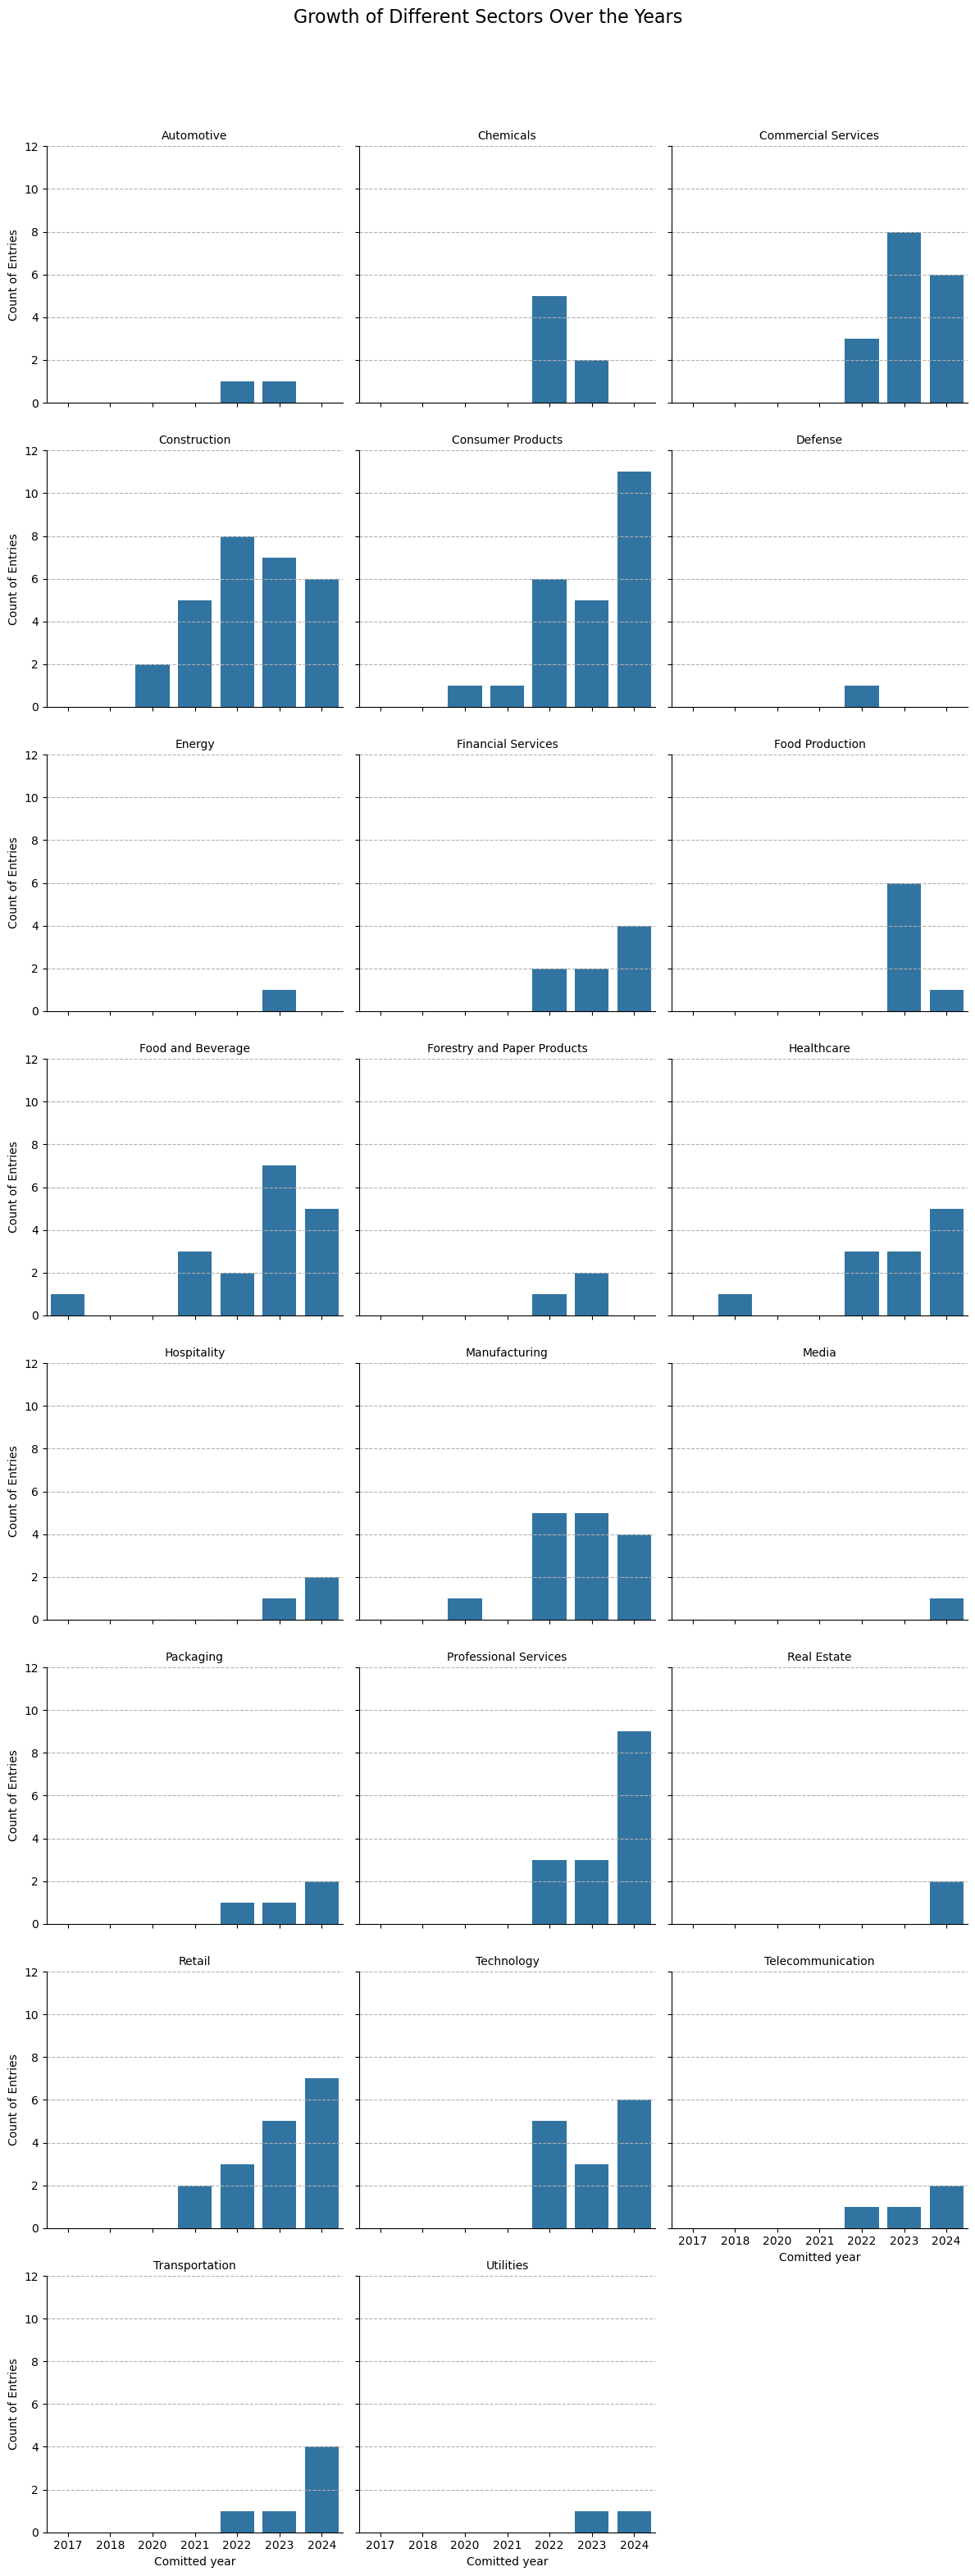

In [26]:
# Assuming sector_growth is already calculated
sector_growth = Targ_dk.groupby(['sectorCat', 'Comitted year']).size().reset_index(name='count')

# Ensure 'Comitted year' is treated as categorical and sorted
sector_growth['Comitted year'] = pd.Categorical(sector_growth['Comitted year'], 
                                                categories=sorted(sector_growth['Comitted year'].unique()), 
                                                ordered=True)

# Create facet grid with shared y-axis
g = sns.FacetGrid(sector_growth, col="sectorCat", col_wrap=3, height=4, sharey=True)
g.map(sns.barplot, "Comitted year", "count", order=sorted(sector_growth['Comitted year'].unique()))

# Customize the layout
g.set_titles("{col_name}")
g.set_axis_labels("Comitted year", "Count of Entries")
g.fig.suptitle("Growth of Different Sectors Over the Years", fontsize=16)
g.fig.tight_layout(rect=[0, 0, 1, 0.95])

# Set y-axis limits and display gridlines for all plots
for ax in g.axes.flat:
    ax.set_ylim(0, 12)        # Set y-axis limits
    ax.yaxis.set_ticks(range(0, 13, 2))  # Explicitly show ticks on y-axis
    ax.grid(axis='y', linestyle='--')    # Add gridlines for better visualization

plt.show()

# I have tried for a long time to show the x-axis correctly but i cant seem to get it to work :(((

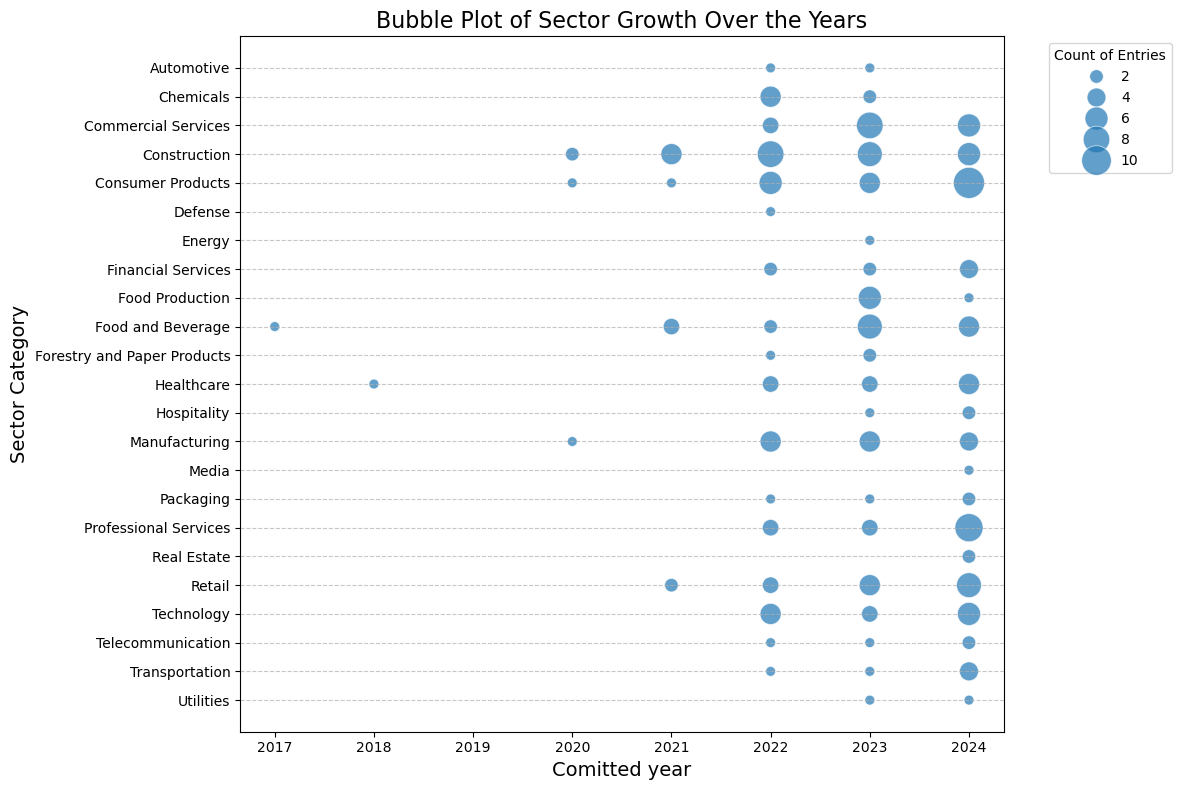

In [27]:
plt.figure(figsize=(12, 8))
bubble_plot = sns.scatterplot(
    data=sector_growth,
    x="Comitted year",
    y="sectorCat",
    size="count",
    sizes=(50, 500),
    alpha=0.7
)

# Add horizontal gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the plot
bubble_plot.set_title("Bubble Plot of Sector Growth Over the Years", fontsize=16)
bubble_plot.set_xlabel("Comitted year", fontsize=14)
bubble_plot.set_ylabel("Sector Category", fontsize=14)
plt.legend(title="Count of Entries", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.show()

## Growth in organisations types

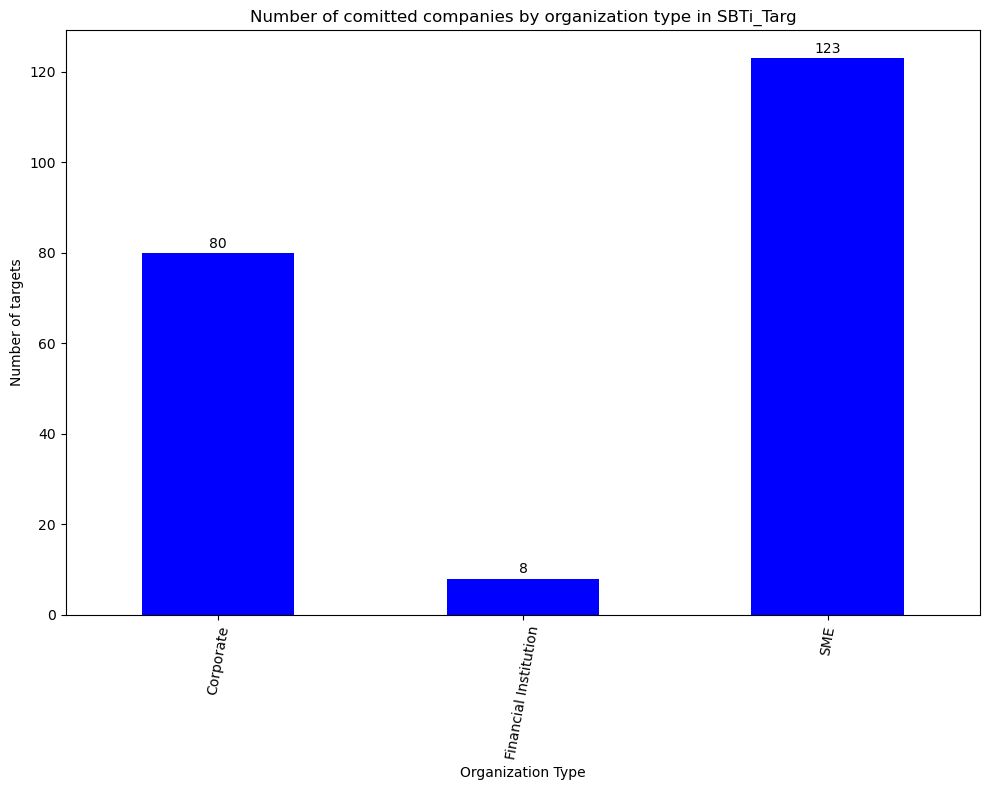

In [28]:
#show growth organization_type over the years
Targ_dk['organization_type'].value_counts().sort_index().plot(kind='bar', figsize=(10, 8), color='blue')
plt.title('Number of comitted companies by organization type in SBTi_Targ')
# Add annotations on each bar showing the amount of targets
for i, v in enumerate(Targ_dk['organization_type'].value_counts().sort_index()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=80,verticalalignment='top')
plt.xlabel('Organization Type')
plt.ylabel('Number of targets')
plt.tight_layout()
plt.show()


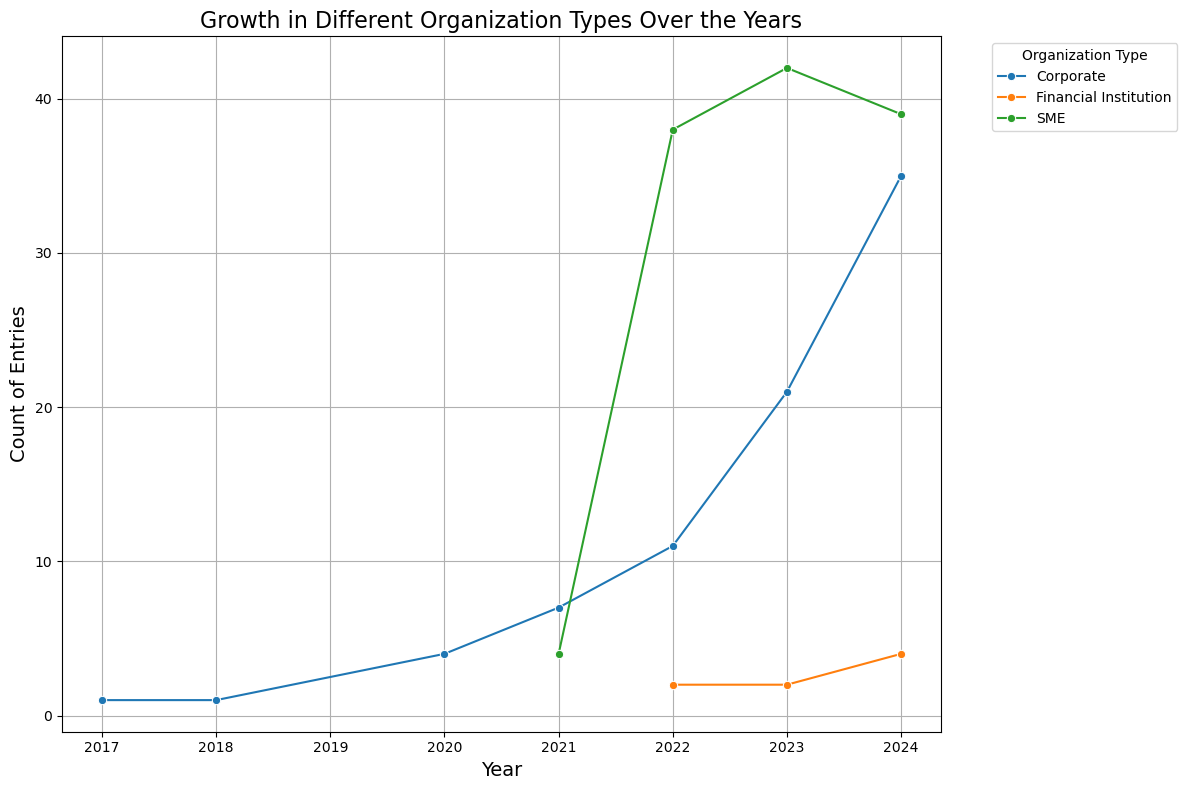

In [29]:
#group organization_type over year_updated years
org_growth = Targ_dk.groupby(['organization_type', 'Comitted year']).size().reset_index(name='count')
org_growth
#plot org_growth
plt.figure(figsize=(12, 8))
sns.lineplot(data=org_growth, x='Comitted year', y='count', hue='organization_type', marker='o')
# Customize the plot
plt.title('Growth in Different Organization Types Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Entries', fontsize=14)
plt.legend(title='Organization Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
# Show the plot
plt.show()
#plot org_growth as barplot


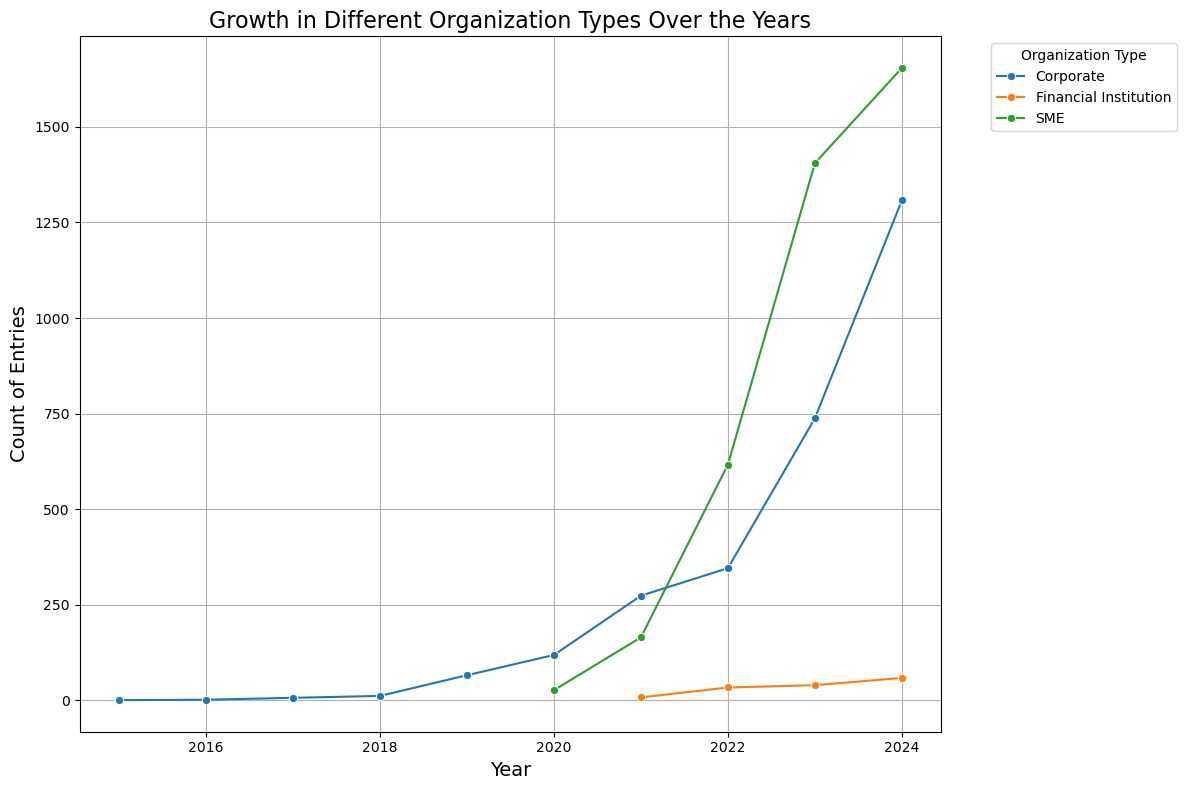

In [46]:
#group organization_type over year_updated years
org_growth2 = Targ.groupby(['organization_type', 'Comitted year']).size().reset_index(name='count')
org_growth2
#plot org_growth2
plt.figure(figsize=(12, 8))
sns.lineplot(data=org_growth2, x='Comitted year', y='count', hue='organization_type', marker='o')
# Customize the plot
plt.title('Growth in Different Organization Types Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Entries', fontsize=14)
plt.legend(title='Organization Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
# Show the plot
plt.show()
#plot org_growth2 as barplot

## What targets does the danish companies sign up with

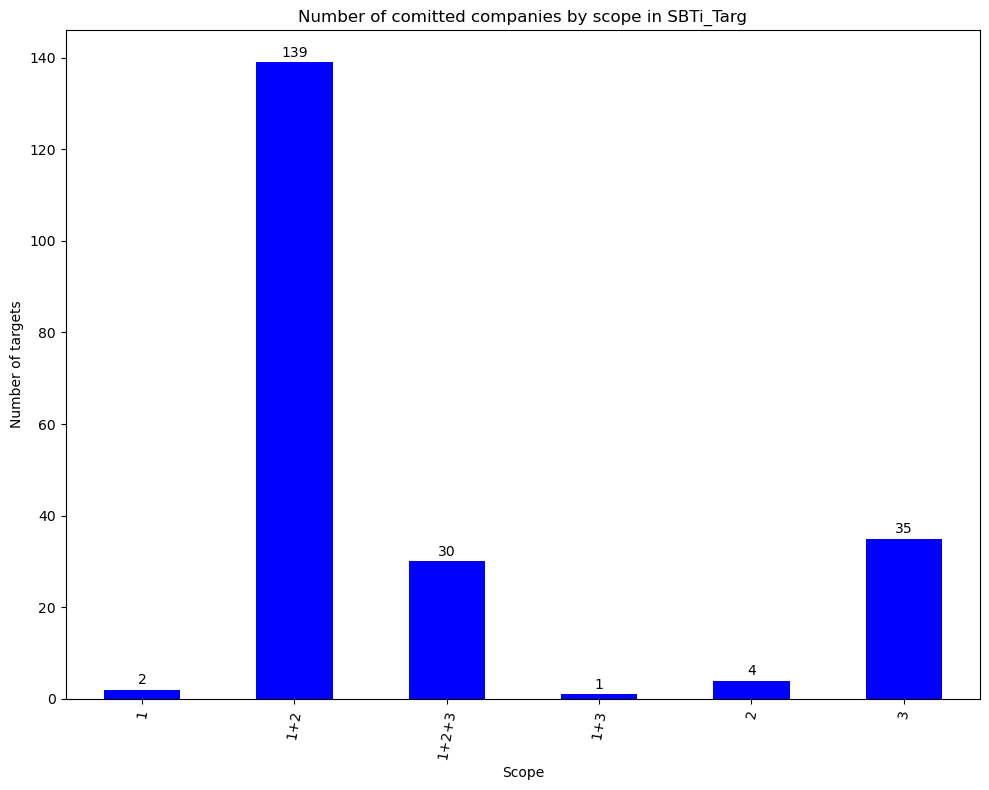

In [31]:
Targ_dk['scope'].unique()
#show growth scope over the years
Targ_dk['scope'].value_counts().sort_index().plot(kind='bar', figsize=(10, 8), color='blue')
plt.title('Number of comitted companies by scope in SBTi_Targ')
# Add annotations on each bar showing the amount of targets
for i, v in enumerate(Targ_dk['scope'].value_counts().sort_index()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=80,verticalalignment='top')
plt.xlabel('Scope')
plt.ylabel('Number of targets')
plt.tight_layout()
plt.show()

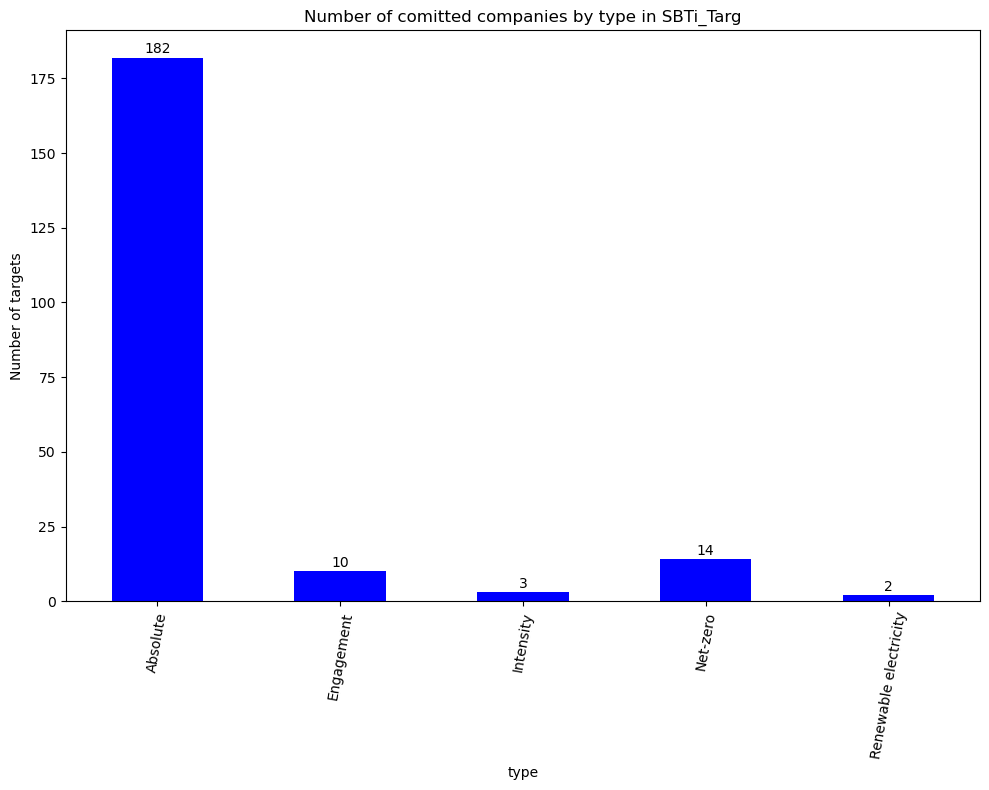

In [32]:
Targ_dk['type'].value_counts().sort_index().plot(kind='bar', figsize=(10, 8), color='blue')
plt.title('Number of comitted companies by type in SBTi_Targ')
# Add annotations on each bar showing the amount of targets
for i, v in enumerate(Targ_dk['type'].value_counts().sort_index()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=80,verticalalignment='top')
plt.xlabel('type')
plt.ylabel('Number of targets')
plt.tight_layout()
plt.show()

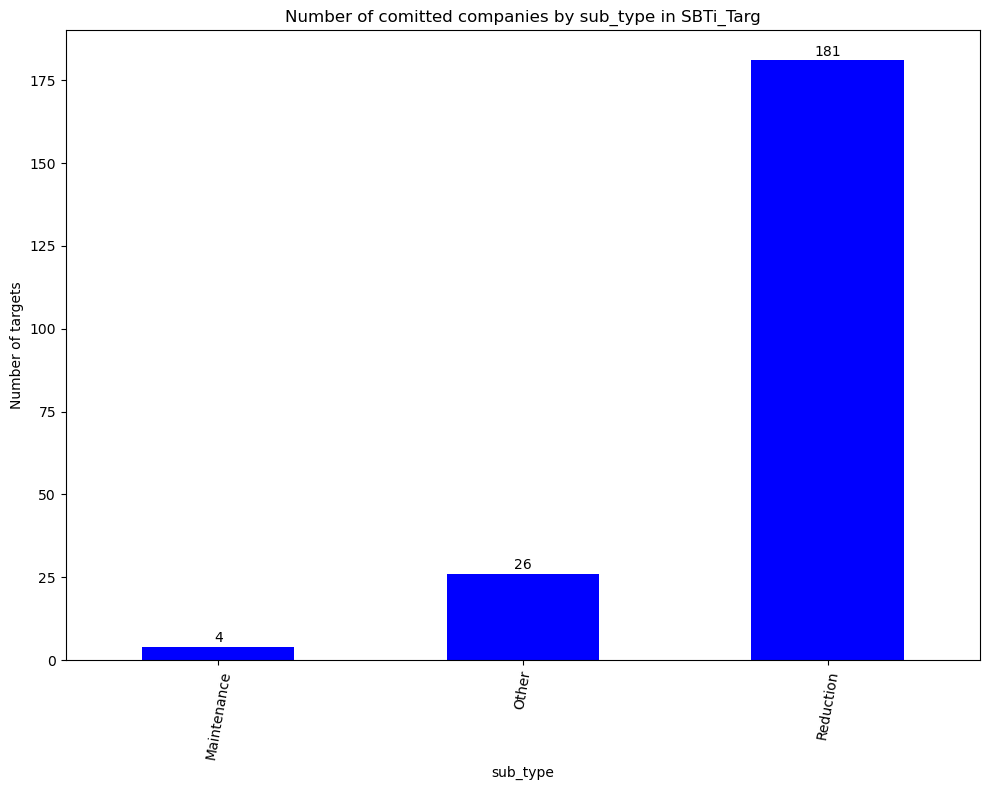

In [33]:
Targ_dk['sub_type'].value_counts().sort_index().plot(kind='bar', figsize=(10, 8), color='blue')
plt.title('Number of comitted companies by sub_type in SBTi_Targ')
# Add annotations on each bar showing the amount of targets
for i, v in enumerate(Targ_dk['sub_type'].value_counts().sort_index()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=80,verticalalignment='top')
plt.xlabel('sub_type')
plt.ylabel('Number of targets')
plt.tight_layout()
plt.show()

# Which companies have removed their commitment? and why?


## Below graphs are fore net_zero commitments that have been removed

In [34]:
#new datafram with only companies removing their commitments to targets
Comp_dk_removed_NZ= Comp_dk[Comp_dk[' net_zero_status'] == 'Commitment removed']

In [35]:
Comp_dk_removed_NZ=Comp_dk_removed_NZ.copy()


In [36]:
Comp_dk_removed_NZ['company_name']

866         Carlsberg Group
4630    Vestas Wind Systems
4100             Stryhns AS
4595          SM Industries
3600           REMONDIS A/S
2870     Merkur Andelskasse
4061            STARK Group
3174                   NREP
1815      GN Store Nord A/S
999                  Clever
670            BioMar Group
3146          Norican Group
3120                   NNIT
Name: company_name, dtype: object

In [37]:
yearly_counts = Comp_dk_removed_NZ.groupby('year_updated').size().reset_index(name='count')
yearly_counts 

,year_updated,count
0,2019,1
1,2020,1
2,2021,1
3,2022,5
4,2023,4
5,2025,1


### Count of removed commitments over the years

   year_updated  count
0          2019      1
1          2020      1
2          2021      1
3          2022      5
4          2023      4
5          2025      1


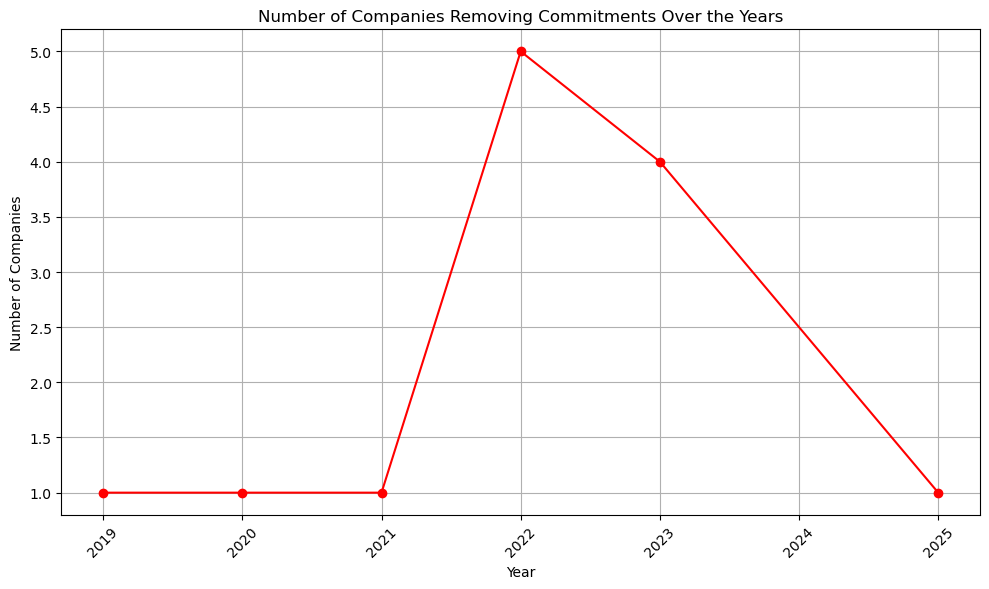

In [38]:
yearly_counts = Comp_dk_removed_NZ.groupby('year_updated').size().reset_index(name='count')
print(yearly_counts)
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts['year_updated'], yearly_counts['count'], marker='o', linestyle='-', color='red')
plt.title('Number of Companies Removing Commitments Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Companies')
#plt.xticks(yearly_counts['year_updated'], rotation=45)
plt.xticks(range(2019,2026,1), rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### Reasons they removed their commitment

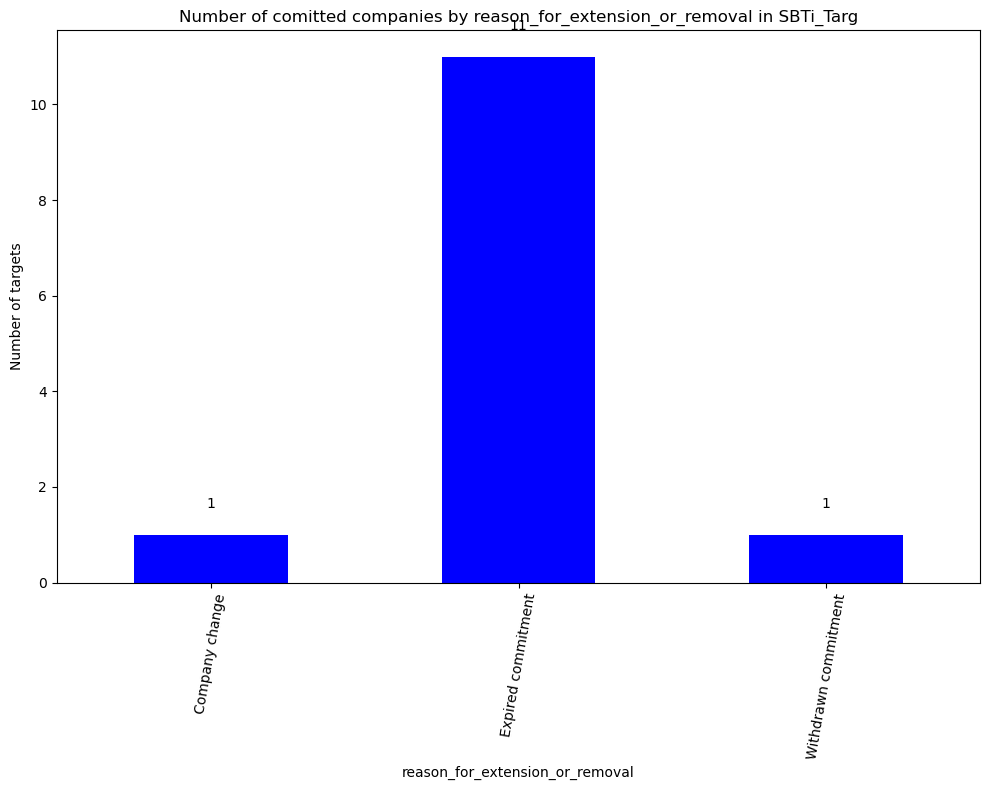

In [39]:
Comp_dk_removed_NZ['reason_for_extension_or_removal'].value_counts().sort_index().plot(kind='bar', figsize=(10, 8), color='blue')
plt.title('Number of comitted companies by reason_for_extension_or_removal in SBTi_Targ')
# Add annotations on each bar showing the amount of targets
for i, v in enumerate(Comp_dk_removed_NZ['reason_for_extension_or_removal'].value_counts().sort_index()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=80,verticalalignment='top')
plt.xlabel('reason_for_extension_or_removal')
plt.ylabel('Number of targets')
plt.tight_layout()
plt.show()

### Sectors that removed their commitments

             sectorCat  count
0         Construction      1
1    Consumer Products      1
2               Energy      1
3   Financial Services      1
4      Food Production      1
5    Food and Beverage      2
6        Manufacturing      2
7          Real Estate      1
8               Retail      1
9           Technology      1
10           Utilities      1


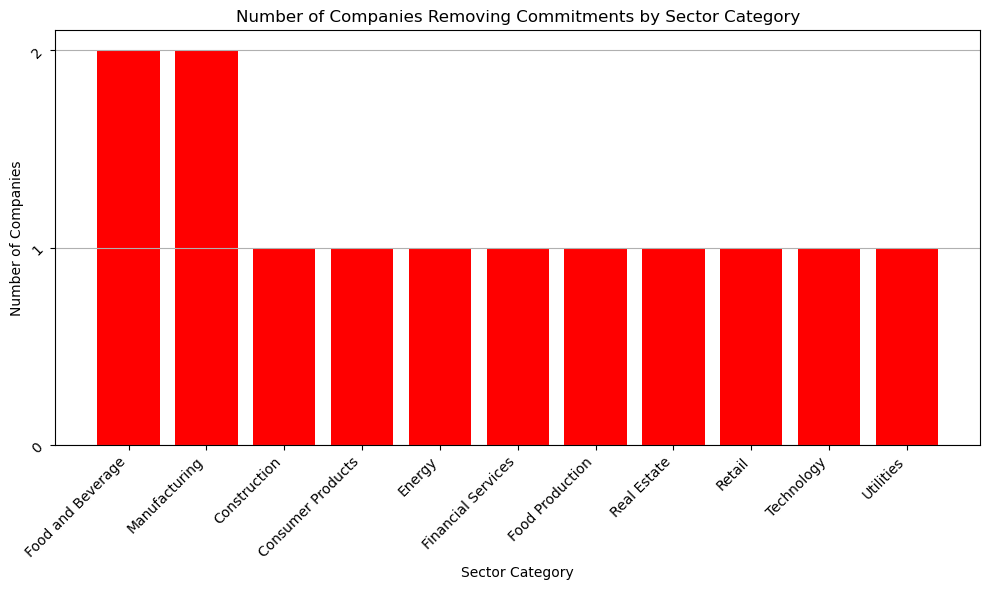

In [40]:
sector_retract_count = Comp_dk_removed_NZ.groupby('sectorCat').size().reset_index(name='count')
print(sector_retract_count)
# Sort by size instead of index
sector_retract_count = sector_retract_count.sort_values(by='count', ascending=False)
# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(sector_retract_count['sectorCat'], sector_retract_count['count'], color='red')
plt.title('Number of Companies Removing Commitments by Sector Category')
plt.xlabel('Sector Category')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45, ha='right')
plt.yticks(range(0,3,1),rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


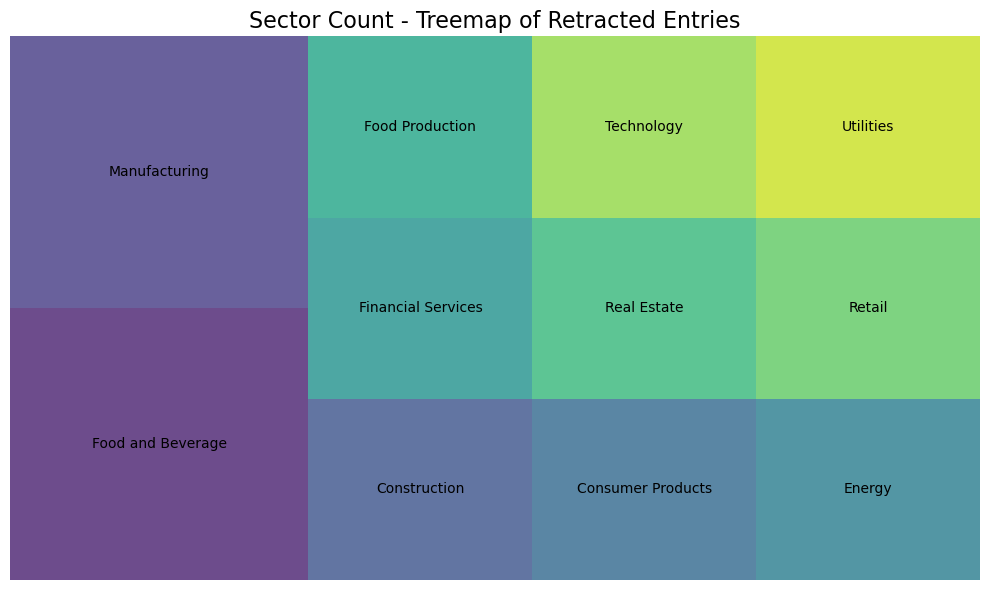

In [41]:
import squarify  # Install with `pip install squarify`

# Create a treemap
plt.figure(figsize=(10, 6))
squarify.plot(
    sizes=sector_retract_count['count'], 
    label=sector_retract_count['sectorCat'], 
    color=sns.color_palette('viridis', len(sector_retract_count)), 
    alpha=0.8
)

# Add title
plt.title('Sector Count - Treemap of Retracted Entries', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

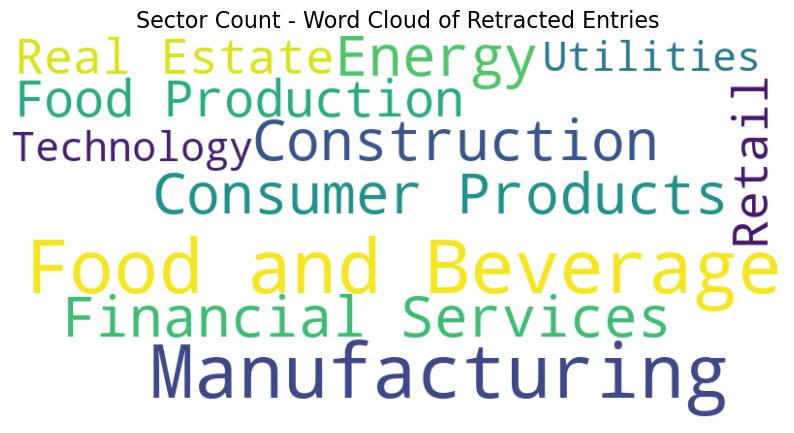

In [42]:
from wordcloud import WordCloud

# Create a dictionary for the word cloud
wordcloud_data = dict(zip(sector_retract_count['sectorCat'], sector_retract_count['count']))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Sector Count - Word Cloud of Retracted Entries', fontsize=16)
plt.show()

In [43]:
sector_retract_count

,sectorCat,count
5,Food and Beverage,2
6,Manufacturing,2
0,Construction,1
1,Consumer Products,1
2,Energy,1
3,Financial Services,1
4,Food Production,1
7,Real Estate,1
8,Retail,1
9,Technology,1


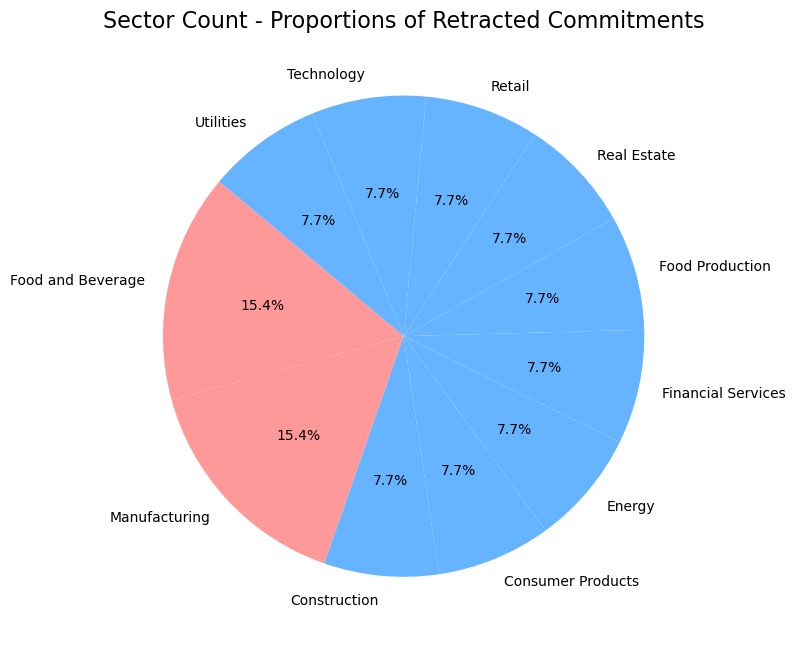

In [44]:
plt.figure(figsize=(8, 8))
colors = ['#ff9999' if count > 1 else '#66b3ff' for count in sector_retract_count['count']]
plt.pie(
    sector_retract_count['count'], 
    labels=sector_retract_count['sectorCat'], 
    autopct='%1.1f%%', startangle=140, colors=colors
)

# Add title
plt.title('Sector Count - Proportions of Retracted Commitments', fontsize=16)
plt.tight_layout()
plt.show()

### Exploration/ comparison of the companies that removed their commitment

In [45]:
Comp_dk_removed_NZ[near_term_status].value_counts()

NameError: name 'near_term_status' is not defined

## Below graphs are for Near_term commitments that have been removed

In [ ]:
#new datafram with only companies removing their commitments to targets
Comp_dk_removed_NT= Comp_dk[Comp_dk['near_term_status'] == 'Commitment removed']

In [ ]:
Comp_dk_removed_NT=Comp_dk_removed_NT.copy()


In [ ]:
Comp_dk_removed_NT['company_name']

2381          Jupiter Bach
2689         LTP Group A/S
4595         SM Industries
3600          REMONDIS A/S
2889       Micro Matic A/S
2870    Merkur Andelskasse
3174                  NREP
999                 Clever
Name: company_name, dtype: object

In [ ]:
yearly_counts = Comp_dk_removed_NT.groupby('year_updated').size().reset_index(name='count')
yearly_counts 

,year_updated,count
0,2021,2
1,2022,5
2,2023,1


   year_updated  count
0          2021      2
1          2022      5
2          2023      1


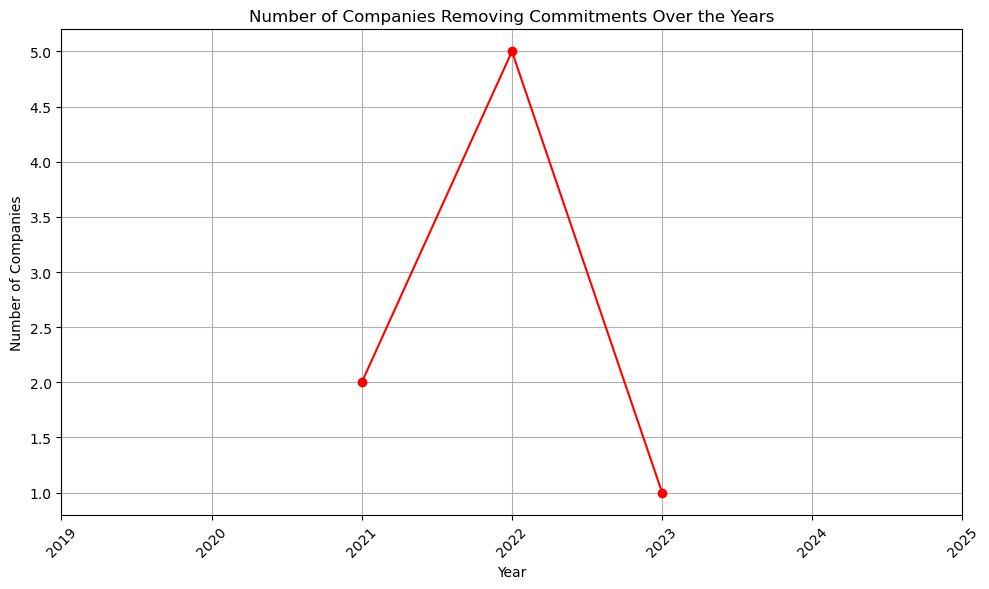

In [ ]:
yearly_counts = Comp_dk_removed_NT.groupby('year_updated').size().reset_index(name='count')
print(yearly_counts)
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts['year_updated'], yearly_counts['count'], marker='o', linestyle='-', color='red')
plt.title('Number of Companies Removing Commitments Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Companies')
#plt.xticks(yearly_counts['year_updated'], rotation=45)
plt.xticks(range(2019,2026,1), rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

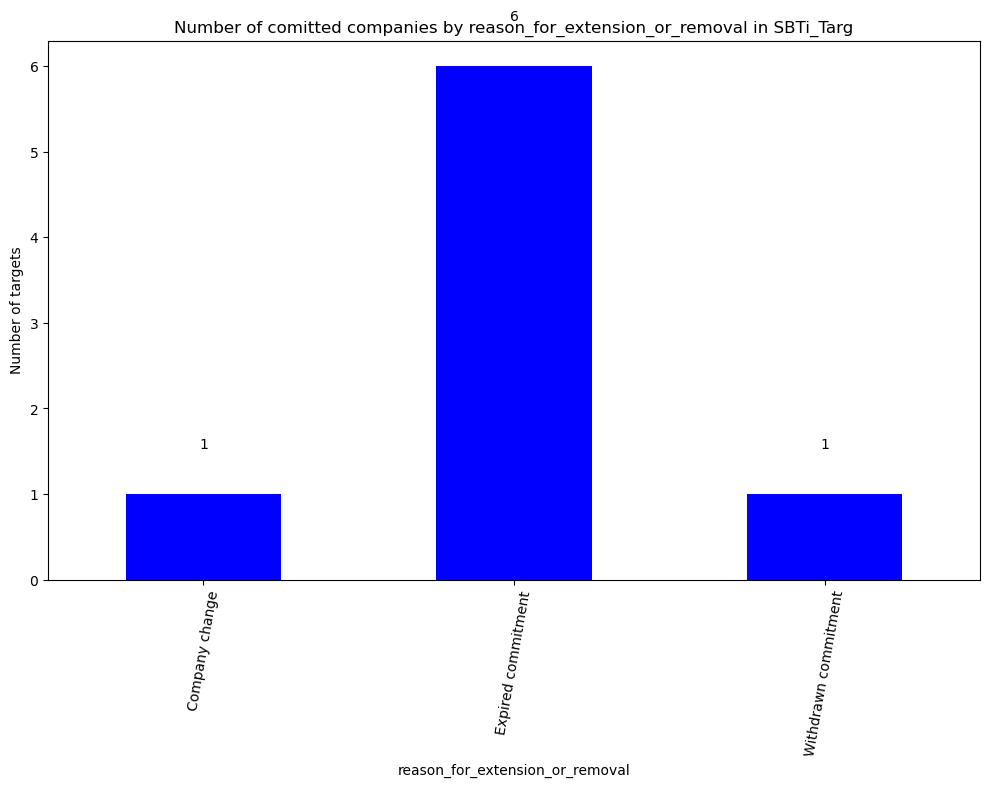

In [ ]:
Comp_dk_removed_NT['reason_for_extension_or_removal'].value_counts().sort_index().plot(kind='bar', figsize=(10, 8), color='blue')
plt.title('Number of comitted companies by reason_for_extension_or_removal in SBTi_Targ')
# Add annotations on each bar showing the amount of targets
for i, v in enumerate(Comp_dk_removed_NT['reason_for_extension_or_removal'].value_counts().sort_index()):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)
plt.xticks(rotation=80,verticalalignment='top')
plt.xlabel('reason_for_extension_or_removal')
plt.ylabel('Number of targets')
plt.tight_layout()
plt.show()

## this is a try
### even more a try
